# Описание данных для сравнения объявлений

**Целевая переменная:** `is_double` (флаг дубля объявлений)

*(где `*` = `base`/`cand`)*

## Группы признаков

### Идентификаторы
- `*_item_id` (str) - ID объявлений  
- `group_id` (int) - группа пользователей  
- `action_date` (datetime) - дата взаимодействия

### Категории
- `*_category_name` (str) - категория  
- `*_subcategory_name` (str) - подкатегория  
- `*_param1`, `*_param2` (str) - детализация  

### Контент
- `*_title`, `*_description` (str) - текст  
- `*_price` (float) - цена  
- `*_count_images` (int) - кол-во фото  
- `*_title_image` (str) - ID главного фото  
- `*_json_params` (json) - атрибуты в JSON

### Гео
- `is_same_location` (bool) - совпадение города  
- `is_same_region` (bool) - совпадение региона

### Таргет
- `is_double` (bool) - дубль объявлений

# Распаковка тренировочных данных (ТЕКСТ)

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pymorphy3  # кирилица
from datetime import date

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Джамиля\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
base_dir = '../data/raw/train/text/'
file_template = 'train_part_{}.snappy.parquet'
NUM_OF_FILES_PREPROC = 1

# Проверяем существование директории
if not os.path.exists(base_dir):
    print(f"Директория не найдена: {os.path.abspath(base_dir)}")
else:
    all_files_exist = all(os.path.exists(base_dir + file_template.format(f"{i:04d}")) for i in range(1, NUM_OF_FILES_PREPROC+1))
    
    if all_files_exist:
        # Загружаем все файлы если они существуют
        train_dfs = [pd.read_parquet(base_dir + file_template.format(f"{i:04d}")) for i in range(1, NUM_OF_FILES_PREPROC+1)]
        train_df = pd.concat(train_dfs, ignore_index=True)
        print("Все файлы успешно загружены!")
    else:
        print("Некоторые файлы отсутствуют:")
        for i in range(1, NUM_OF_FILES_PREPROC+1): 
            file_path = base_dir + file_template.format(f"{i:04d}")
            if not os.path.exists(file_path):
                print(f"- Отсутствует: {file_path}")

Все файлы успешно загружены!


In [56]:
train_df.shape

(500000, 27)

In [57]:
missing_values = train_df.isnull().sum()
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values[missing_values > 0],
    'Тип данных': [train_df[col].dtype for col in missing_values[missing_values > 0].index]
})

print("\nИнформация о пропущенных значениях:")
print(missing_info)


Информация о пропущенных значениях:
                       Количество пропусков Тип данных
base_category_name                        3     object
base_subcategory_name                     3     object
base_param1                           19628     object
cand_param1                           19914     object
base_param2                          157666     object
cand_param2                          158232     object
base_count_images                      9553    float64
cand_count_images                      9351    float64


## Устранение пропусков

In [58]:
# Замена пропущенных значений в числовых столбцах на 0.0
numeric_columns = ['base_count_images', 'cand_count_images']
train_df[numeric_columns] = train_df[numeric_columns].fillna(0.0)

# Замена пропущенных значений в строковых столбцах на " "
object_columns = ['base_category_name', 'base_subcategory_name', 
                  'base_param1', 'cand_param1', 'base_param2', 'cand_param2']
train_df[object_columns] = train_df[object_columns].fillna(" ")

In [59]:
# Проверяем оставшиеся нулевые значения
print("Осталось пропусков после очистки:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

Осталось пропусков после очистки:
Series([], dtype: int64)


In [60]:
train_df.shape

(500000, 27)

## Нормализация текста

In [ ]:
# TODO нормализовать только нужные строки, допустим id не нужно и тд
# TODO почитать про векторизацию на каком этапе это приминяют и нужно ли нам?
"""
# функция которая сводит все слова к простейшей форме
morph = pymorphy3.MorphAnalyzer() 

def clean_text(text):
    if pd.isna(text): return "" # показушная предосторожность, хотя мы избавились от нулов
    
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9\s]', '', text)  # оставить тока цыфры и буквы(лат и кир)
    text = re.sub(r'\s+', ' ', text).strip() # лишние пробелы
    
    tokens = []
    for word in text.split():
        if word not in stopwords.words('russian'):
            parsed = morph.parse(word)
            if parsed:
                tokens.append(parsed[0].normal_form)
    
    return ' '.join(tokens)


text_columns = []
for col in train_df.select_dtypes(include=['object']).columns:
    if not any(isinstance(x, date) for x in train_df[col] if pd.notna(x)):
        text_columns.append(col)
original_texts = train_df[text_columns].copy()

# для всех текстовых полей обработать текст
for col in text_columns:
    print(f"Обрабатываю колонку: {col}")
    train_df[col] = train_df[col].map(lambda x: clean_text(x) if pd.notna(x) else x)

for i in range(3):
    for col in text_columns[:1]:
        before = original_texts.iloc[i][col]
        after = train_df.iloc[i][col]
        print(f"Пример {i+1} (колонка '{col}'):")
        print(f"До: {before}")
        print(f"После: {after}")
        print("-" * 50)

"""

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_16216\1543644554.py:1: SyntaxWarning: invalid escape sequence '\s'
  """


'\n# функция которая сводит все слова к простейшей форме\nmorph = pymorphy3.MorphAnalyzer() \n\ndef clean_text(text):\n    if pd.isna(text): return "" # показушная предосторожность, хотя мы избавились от нулов\n\n    text = text.lower()\n    text = re.sub(r\'[^а-яёa-z0-9\\s]\', \'\', text)  # оставить тока цыфры и буквы(лат и кир)\n    text = re.sub(r\'\\s+\', \' \', text).strip() # лишние пробелы\n\n    tokens = []\n    for word in text.split():\n        if word not in stopwords.words(\'russian\'):\n            parsed = morph.parse(word)\n            if parsed:\n                tokens.append(parsed[0].normal_form)\n\n    return \' \'.join(tokens)\n\n\ntext_columns = []\nfor col in train_df.select_dtypes(include=[\'object\']).columns:\n    if not any(isinstance(x, date) for x in train_df[col] if pd.notna(x)):\n        text_columns.append(col)\noriginal_texts = train_df[text_columns].copy()\n\n# для всех текстовых полей обработать текст\nfor col in text_columns:\n    print(f"Обрабатываю

In [ ]:
base_dir = '../data/processed/'
file_name = 'train_text.json'

# Проверяем существование директории
if not os.path.exists(base_dir):
    print(f"Директория не найдена: {os.path.abspath(base_dir)}")
else:
    # Сохраняем DataFrame в JSON файл
    train_df.to_json(base_dir + file_name, orient='records', indent=4)
    print(f"Данные успешно сохранены в файл: {base_dir + file_name}")


Данные успешно сохранены в файл: ../data/processedtrain_text.json


# EDA: Aнализ базы данных

### Пропорция дупликатов

Target distribution:
 is_double
0    0.938822
1    0.061178
Name: proportion, dtype: float64


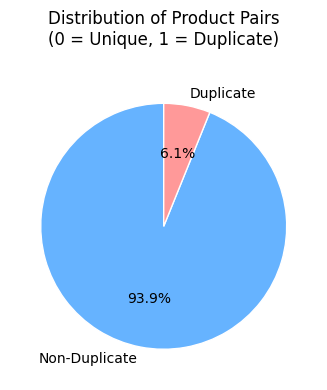

In [62]:
import matplotlib.pyplot as plt

# Target distribution
target_dist = train_df['is_double'].value_counts(normalize=True)
print("Target distribution:\n", target_dist)

# Create pie plot
plt.figure(figsize=(4, 4))
plt.pie(
    target_dist,
    labels=['Non-Duplicate', 'Duplicate'], 
    autopct='%.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'], 
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Add title and make it look clean
plt.title('Distribution of Product Pairs\n(0 = Unique, 1 = Duplicate)', pad=20)
plt.tight_layout()
plt.show()

### Колличество символов в описаниях

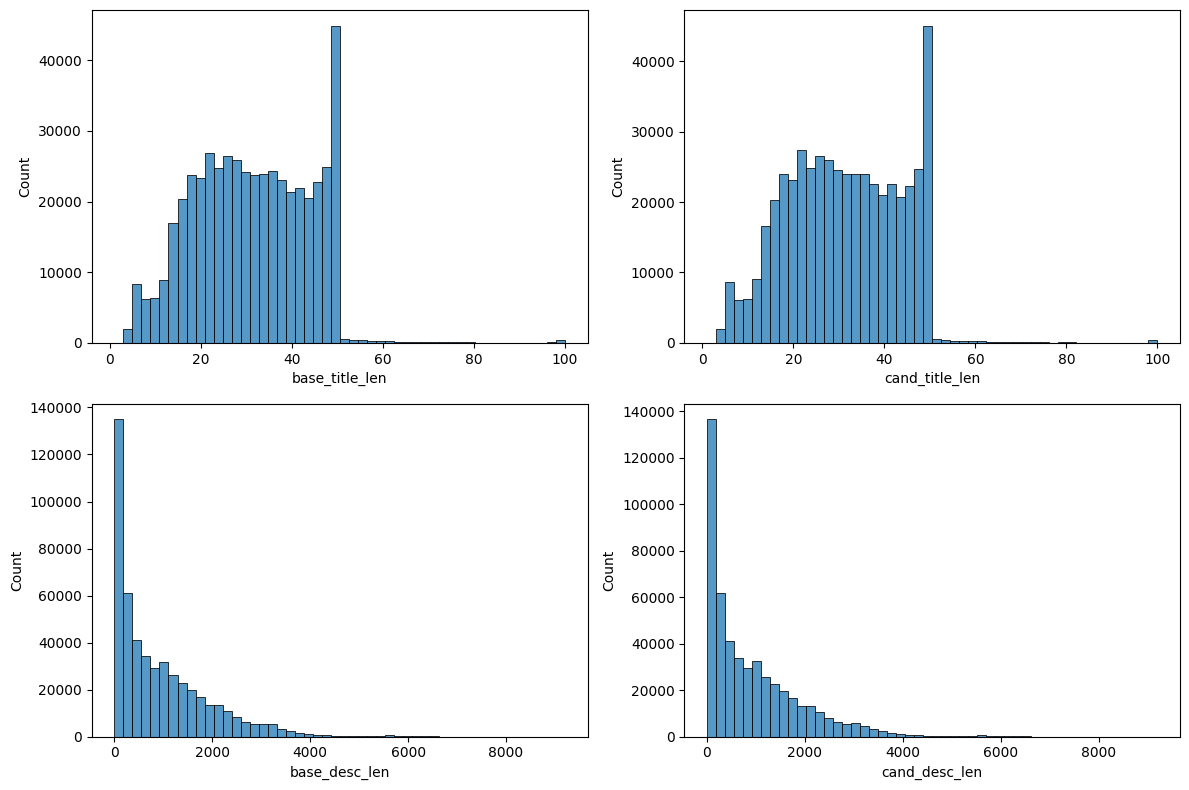

In [65]:
# Text length analysis
train_df['base_title_len'] = train_df['base_title'].str.len()
train_df['cand_title_len'] = train_df['cand_title'].str.len()
train_df['base_desc_len'] = train_df['base_description'].str.len()
train_df['cand_desc_len'] = train_df['cand_description'].str.len()

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(train_df['base_title_len'], ax=axes[0, 0], bins=50)
sns.histplot(train_df['cand_title_len'], ax=axes[0, 1], bins=50)
sns.histplot(train_df['base_desc_len'], ax=axes[1, 0], bins=50)
sns.histplot(train_df['cand_desc_len'], ax=axes[1, 1], bins=50)
plt.tight_layout()
plt.show()

### Цена дубликатов: сколько стоят продублированные товары

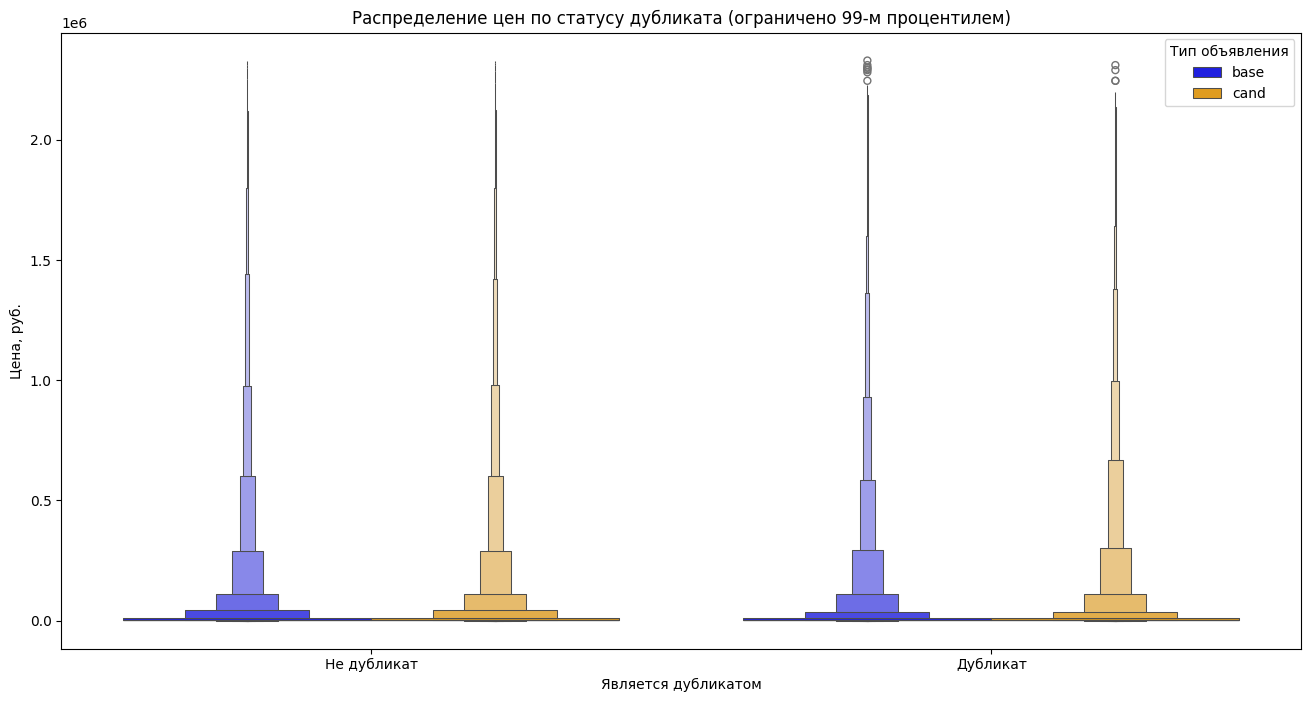

In [80]:
plt.figure(figsize=(16, 8))

# Создаем временный DataFrame с ценами и статусом дубликата
price_data = {
    'price': np.concatenate([train_df['base_price'].values, train_df['cand_price'].values]),
    'is_double': np.repeat(train_df['is_double'].values, 2),
    'ad_type': np.tile(['base', 'cand'], len(train_df))
}

price_df = pd.DataFrame(price_data)

# Ограничиваем 99-м процентилем (исключаем выбросы)
price_cap = price_df['price'].quantile(0.99)
price_df_capped = price_df[price_df['price'] <= price_cap]

# Строим boxenplot
sns.boxenplot(
    x='is_double', 
    y='price', 
    data=price_df_capped, 
    hue='ad_type', 
    palette={'base': 'blue', 'cand': 'orange'}
)

plt.title('Распределение цен по статусу дубликата (ограничено 99-м процентилем)')
plt.xlabel('Является дубликатом')
plt.ylabel('Цена, руб.')
plt.xticks([0, 1], ['Не дубликат', 'Дубликат'])
plt.legend(title='Тип объявления')
plt.show()

### Разница в цене между дубликатами

In [91]:
duplicates = train_df[train_df['is_double'] == 1].copy()

duplicates['price_diff'] = duplicates['base_price'] - duplicates['cand_price']
duplicates['price_diff_pct'] = (duplicates['price_diff'] / duplicates['base_price']) * 100
duplicates['abs_price_diff_pct'] = duplicates['price_diff_pct'].abs()

# статистика по абсолютной процентной разнице
stats = {
    "zero_diff_count": (duplicates['abs_price_diff_pct'] == 0).sum(),
    "zero_diff_ratio": (duplicates['abs_price_diff_pct'] == 0).mean(),
    "small_diff_count": (duplicates['abs_price_diff_pct'] <= 1).sum(),  # <= 1%
    "small_diff_ratio": (duplicates['abs_price_diff_pct'] <= 1).mean(),
    "medium_diff_count": ((duplicates['abs_price_diff_pct'] > 1) & (duplicates['abs_price_diff_pct'] <= 5)).sum(),
    "medium_diff_ratio": ((duplicates['abs_price_diff_pct'] > 1) & (duplicates['abs_price_diff_pct'] <= 5)).mean(),
    "large_diff_count": (duplicates['abs_price_diff_pct'] > 5).sum(),  # > 5%
    "large_diff_ratio": (duplicates['abs_price_diff_pct'] > 5).mean(),
    "max_diff": duplicates['abs_price_diff_pct'].max(),
    "min_diff": duplicates['abs_price_diff_pct'].min(),
    "median_diff": duplicates['abs_price_diff_pct'].median(),
    "mean_diff": duplicates['price_diff_pct'].mean(),
    "std_diff": duplicates['price_diff_pct'].std()
}

print("Статистика:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, (float, int)) else f"{key}: {value}")

Статистика:
zero_diff_count: 12563
zero_diff_ratio: 0.41
small_diff_count: 13477
small_diff_ratio: 0.44
medium_diff_count: 1787
medium_diff_ratio: 0.06
large_diff_count: 15293
large_diff_ratio: 0.50
max_diff: inf
min_diff: 0.00
median_diff: 5.03
mean_diff: nan
std_diff: nan


c:\Users\Джамиля\Documents\project file\for cv\AvitoMLCup\venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


### Категрия дубликатов

In [82]:
category_stats = (train_df.groupby('category')['is_double']
                 .agg(['mean', 'count'])
                 .sort_values('mean', ascending=False)
                 .reset_index())

plt.figure(figsize=(14, 8))
sns.barplot(x='mean', y='category', 
           data=category_stats.head(20),
           palette='viridis')
plt.title('Top 20 Categories by Duplicate Rate')
plt.xlabel('Duplicate Rate')
plt.show()

KeyError: 'category'

### Сходство текстовых полей дубликатов

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(group):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
    tfidf = vectorizer.fit_transform(group['clean_text'])
    return cosine_similarity(tfidf[0:1], tfidf[1:])[0][0]

# Analyze duplicate pairs
duplicate_pairs = train_df[train_df['is_double'] == 1].groupby('group_id').filter(lambda x: len(x) > 1)
sample_duplicates = duplicate_pairs.groupby('group_id').apply(calculate_similarity).reset_index()

# Analyze random non-duplicate pairs
non_duplicate_sample = train_df[train_df['is_double'] == 0].sample(1000)
non_duplicate_sim = cosine_similarity(
    TfidfVectorizer(max_features=5000).fit_transform(non_duplicate_sample['clean_text'])
)

# Visualization
plt.figure(figsize=(12, 6))
sns.kdeplot(sample_duplicates[0], label='Duplicates', bw_adjust=0.5)
sns.kdeplot(non_duplicate_sim.flatten(), label='Non-duplicates', bw_adjust=0.5)
plt.title('Text Similarity Distribution Comparison')
plt.xlabel('Cosine Similarity Score')
plt.legend()
plt.show()

KeyError: 'clean_text'

### Можно ли предсказать является ли кандитат дубликатом по времени когда объявление было опубликовано?

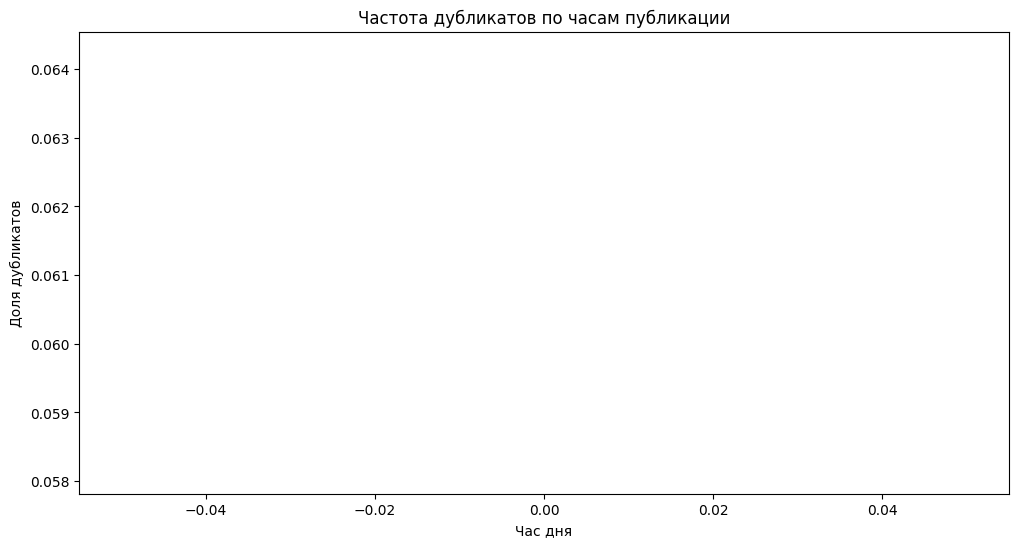

In [83]:
train_df['action_date'] = pd.to_datetime(train_df['action_date'])

# Почасовой анализ дубликатов
train_df['hour'] = train_df['action_date'].dt.hour
hourly_duplicates = train_df.groupby('hour')['is_double'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_duplicates.index, y=hourly_duplicates.values)
plt.title('Частота дубликатов по часам публикации')
plt.ylabel('Доля дубликатов')
plt.xlabel('Час дня')
plt.show()


### Зависимость характеристик друг от друга

c:\Users\Джамиля\Documents\project file\for cv\AvitoMLCup\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_16216\2736015446.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_matrix.values, y=corr_matrix.index, palette='coolwarm')


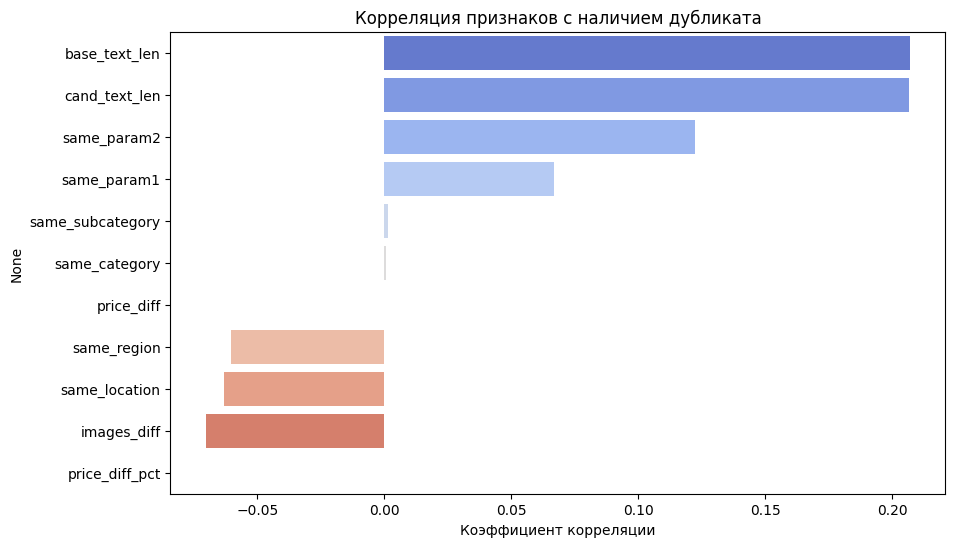

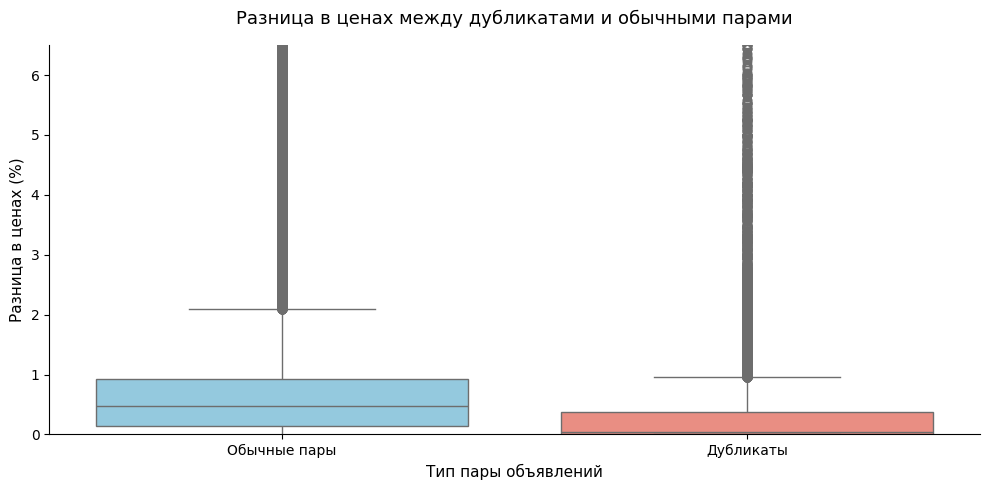

In [88]:
# Создаем матрицу признаков
features = pd.DataFrame({
    'base_text_len': train_df['base_title'].str.len() + train_df['base_description'].str.len(),
    'cand_text_len': train_df['cand_title'].str.len() + train_df['cand_description'].str.len(),
    'price_diff': abs(train_df['base_price'] - train_df['cand_price']),
    'price_diff_pct': abs(train_df['base_price'] - train_df['cand_price']) / train_df['base_price'],
    'images_diff': abs(train_df['base_count_images'] - train_df['cand_count_images']),
    'same_category': (train_df['base_category_name'] == train_df['cand_category_name']).astype(int),
    'same_subcategory': (train_df['base_subcategory_name'] == train_df['cand_subcategory_name']).astype(int),
    'same_param1': (train_df['base_param1'] == train_df['cand_param1']).astype(int),
    'same_param2': (train_df['base_param2'] == train_df['cand_param2']).astype(int),
    'same_location': train_df['is_same_location'].astype(int),
    'same_region': train_df['is_same_region'].astype(int)
})

# Вычисляем корреляции
corr_matrix = features.corrwith(train_df['is_double']).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_matrix.values, y=corr_matrix.index, palette='coolwarm')
plt.title('Корреляция признаков с наличием дубликата')
plt.xlabel('Коэффициент корреляции')
plt.show()

plt.figure(figsize=(10, 5))

# Создаем временный DataFrame для визуализации
plot_data = pd.DataFrame({
    'is_double': train_df['is_double'].astype(int).astype(str),  # Преобразуем в строку
    'price_diff_pct': features['price_diff_pct']
})

# Упрощенный boxplot с явным указанием hue
sns.boxplot(x='is_double',
            y='price_diff_pct',
            data=plot_data,
            hue='is_double',  # Добавляем hue
            palette={'0': "skyblue", '1': "salmon"},
            legend=False)  # Отключаем легенду

# Четкие подписи
plt.title('Разница в ценах между дубликатами и обычными парами', pad=15, fontsize=13)
plt.xlabel('Тип пары объявлений', fontsize=11)
plt.ylabel('Разница в ценах (%)', fontsize=11)

# Простые метки
plt.xticks([0, 1], 
           ['Обычные пары', 
            'Дубликаты'])

# Ограничиваем размах по оси Y для лучшей читаемости
plt.ylim(0, plot_data['price_diff_pct'].quantile(0.95))

# Чистое оформление
sns.despine()
plt.tight_layout()
plt.show()